# Dataiku: Classification problem project

## Bruno Pilarczyk

09/01/2020

# Context

The data we have can be found at http://www.census.gov/ftp/pub/DES/www/welcome.html. It is composed of 199 523 individuals for the train set and 99 762 for the test set. The aim is to predict whether an instance has an annual income higher than 50 000$ per year or not. To do so we have 41 explanatory variables (both qualitative and quantitative ones). We assume some of them will help us predict whether the instance has more than 50K or not.

# Packages

## Package to download if they are not already on your computer:

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Packages to load

In [10]:
# Data handling:
import pandas as pd

# Maths:
import numpy as np
import matplotlib.pyplot as plt

#Plots:
import seaborn as sns

#Missing values:
import missingno as msno

import re

#Several functions:
from sklearn import preprocessing

#Removing chracters in string:
import re

#Over-sampling:
from imblearn.over_sampling import SMOTE

#Metrics:
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import RobustScaler

#Logistic regression:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Python script for confusion matrix creation:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

#ROC Curve:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Extreme Gradient Boosting interface:
import xgboost as xgb

pd.set_option('display.max_columns', 300) #we want to show loads of columns: 57 features + 1 label = 58
pd.set_option('display.max_rows', 300) #we want to show loads of rows

Using TensorFlow backend.


# 1 Loading the data

Let's begin by importing both train and test sets. We have to pay attention to the missing values format which can takes several forms as well as setting no header. Indeed we will set the column names afterwards.

In [11]:
#Path of the files:
path_train = "/Users/brunopilarczyk/Documents/Pro/Dataiku/us_census_full/census_income_learn.csv"
path_test = "/Users/brunopilarczyk/Documents/Pro/Dataiku/us_census_full/census_income_test.csv"

#Missing value detection:
missing_values = [" Not in universe"," ?"]

#Importing both datasets:
train = pd.read_csv(path_train, header = None, na_values = missing_values)
test = pd.read_csv(path_test, header = None, na_values = missing_values)


#Correct column names:
column_names = ["AAGE","ACLSWKR","ADTIND","ADTOCC","AHGA","AHRSPAY","AHSCOL","AMARITL",
                 "AMJIND","AMJOCC","ARACE","AREORGN","ASEX","AUNMEM","AUNTYPE","AWKSTAT","CAPGAIN",
                 "CAPLOSS","DIVVAL","FILESTAT","GRINREG","GRINST","HHDFMX","HHDREL",
                 "MARSUPWT","MIGMTR1","MIGMTR3","MIGMTR4","MIGSAME","MIGSUN","NOEMP","PARENT",
                 "PEFNTVTY","PEMNTVTY","PENATVTY","PRCITSHP","SEOTR",
                 "VETQVA","VETYN","WKSWORK","YEAR","INCOME"]

train.columns = column_names
test.columns = column_names

We can indicate whether a data set becomes from the test set or not by creating a binary variable; before merging them into one dataset named `df`.

In [12]:
train["testing"] = 0
test["testing"] = 1
df = pd.concat([train, test], sort = False)

First look:

In [13]:
df.head(5)

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MARSUPWT,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,INCOME,testing
0,73,NaN,0,0,High school graduate,0,NaN,Widowed,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Not in labor force,0,0,0,Nonfiler,NaN,NaN,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,White,All other,Male,NaN,NaN,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.,0
2,18,NaN,0,0,10th grade,0,High school,Never married,Not in universe or children,NaN,Asian or Pacific Islander,All other,Female,NaN,NaN,Not in labor force,0,0,0,Nonfiler,NaN,NaN,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,NaN,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,NaN,2,0,95,- 50000.,0
3,9,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Children or Armed Forces,0,0,0,Nonfiler,NaN,NaN,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,NaN,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.,0
4,10,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Children or Armed Forces,0,0,0,Nonfiler,NaN,NaN,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,NaN,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.,0


Data structure (data types):

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 43 columns):
AAGE        199523 non-null int64
ACLSWKR     99278 non-null object
ADTIND      199523 non-null int64
ADTOCC      199523 non-null int64
AHGA        199523 non-null object
AHRSPAY     199523 non-null int64
AHSCOL      12580 non-null object
AMARITL     199523 non-null object
AMJIND      199523 non-null object
AMJOCC      98839 non-null object
ARACE       199523 non-null object
AREORGN     199523 non-null object
ASEX        199523 non-null object
AUNMEM      19064 non-null object
AUNTYPE     6070 non-null object
AWKSTAT     199523 non-null object
CAPGAIN     199523 non-null int64
CAPLOSS     199523 non-null int64
DIVVAL      199523 non-null int64
FILESTAT    199523 non-null object
GRINREG     15773 non-null object
GRINST      15065 non-null object
HHDFMX      199523 non-null object
HHDREL      199523 non-null object
MARSUPWT    199523 non-null float64
MIGMTR1     98311 non-null o

At first look the data needs to be cleaned before having to be transformed and prepared. 

# 2 Data Cleaning

## 2.1 Dealing with missing values

Let's see how many missing values are there.

In [15]:
df.isna().sum().sum()

2964010

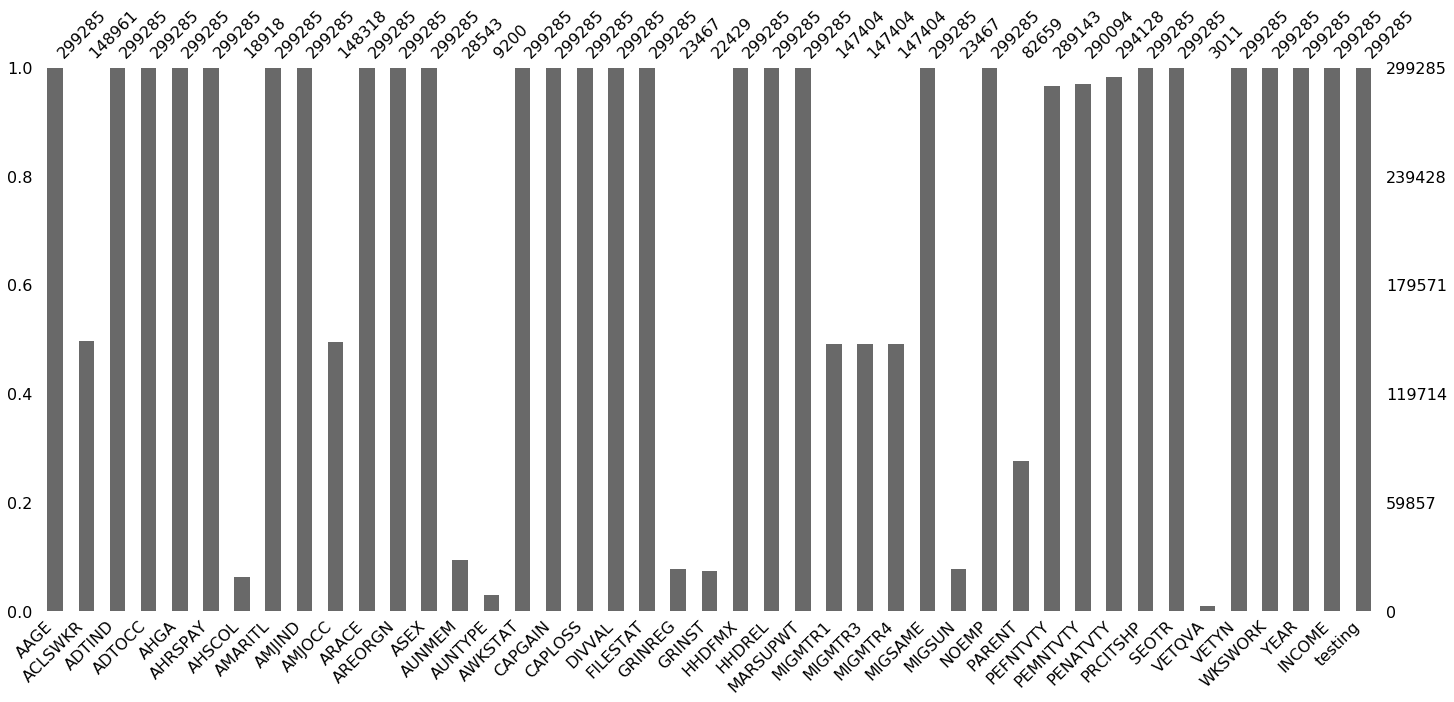

In [16]:
msno.bar(df)

We can easily see that some variables contains more than 50% of missing values (over the total number of observations), hence we can delete them because trying to fill those ones will result in poor predictions.

In [17]:
#Variables containing less than 50% of NAs
var_to_keep = df.isna().sum()/df.shape[0] < 0.5

#We keep all variables in var_to_keep (<50% NAs)
df = df.loc[:,var_to_keep]

Even if we delete columns containing too much NAs, three variables are still showing NAs. These three columns are respectively the country of birth of the father, the mother and the one of the individual concerned. We cannot predict significantly a missing information about one those three columns based on the other ones. For example we know the country of birth of both the father and the mother, it is not sure that it will be the same for individual. Worse, in some cases we do not know neither of them.

In [18]:
df.loc[range(11,19),df.isna().sum()/df.shape[0] > 0]

,PEFNTVTY,PEMNTVTY,PENATVTY
11,NaN,NaN,NaN
11,United-States,United-States,United-States
12,United-States,United-States,United-States
12,Trinadad&Tobago,Trinadad&Tobago,Trinadad&Tobago
13,Columbia,Columbia,Columbia
13,United-States,United-States,United-States
14,United-States,United-States,United-States
14,United-States,United-States,United-States
15,United-States,United-States,United-States
15,United-States,United-States,United-States


## 2.2 Treating NAs from `PEFNTVTY`, `PEMNTVTY`, `PENATVTY`

It can be useful to treat NAs from `PEFNTVTY`, `PEMNTVTY`, `PENATVTY` as an information. It means that the fact that we do not know the country from the father or the mother for example is an information. We could have used an algorithm such like KNN in order to predict missing values from those features, but I think it is smarter, in this case, to do it that way as a missing value represents an information to be taken into account.

In [19]:
for column_name in df.columns:
    if df[column_name].dtype == "object":
        df[column_name] = df[column_name].astype(str)

## 2.3 Changing `ADTIND` and `ADTOCC` into categorical variables

In [20]:
to_change = ['ADTIND', 'ADTOCC']

In [21]:
for variable in to_change:
    df[variable] = df[variable].astype(str)

# 3 Data exploration and preparation

## 3.1 Dependent variable distribution (`INCOME`)

Let us focus on the distribution of the dependent variable `INCOME`. First we have to transform it into a binary variable which will indicate 1 if the income if higher than $50000, 0 if it is lower.

`INCOME` = $\begin{cases}
1 \text{ if the individual earned more than \$50 000"} \\
0 \text{ otherwise} \end{cases}$

In [22]:
df.INCOME.unique()

array([' - 50000.', ' 50000+.'], dtype=object)

In [23]:
df['INCOME'] = np.where(df['INCOME'] ==  " 50000+.", 1, 0)

Let us see what is the percentage of people having more than 50K depending on we consider the train set or the test set

In [24]:
print(round(sum(df[df.testing == 0]['INCOME'])/df[df.testing == 0].shape[0]*100,2),"%")
print(round(sum(df[df.testing == 1]['INCOME'])/df[df.testing == 1].shape[0]*100,2),"%")

6.21 %
6.2 %


The proportion of people earning more than 50K/year is roughly the same whithin both data sets.

## 3.2 Explanatory variables

### Function for correlation

In [25]:
def corr(list_of_var, data):
    corr = data[list_of_var].corr()
    return corr.style.background_gradient(cmap='coolwarm')

### `AAGE` : age

In [26]:
df.AAGE.describe()

count    299285.000000
mean         34.538998
std          22.318468
min           0.000000
25%          15.000000
50%          33.000000
75%          50.000000
max          90.000000
Name: AAGE, dtype: float64

People are around 34/35 years old on average, the younger person is 0 year old which is uncommon and could be treated as an outlier, but as people having an of 0 are presents in both data sets, we will not erase those observations as the algorithm will be not able to predict them afterwards. The maximum is 90, it makes sense. 

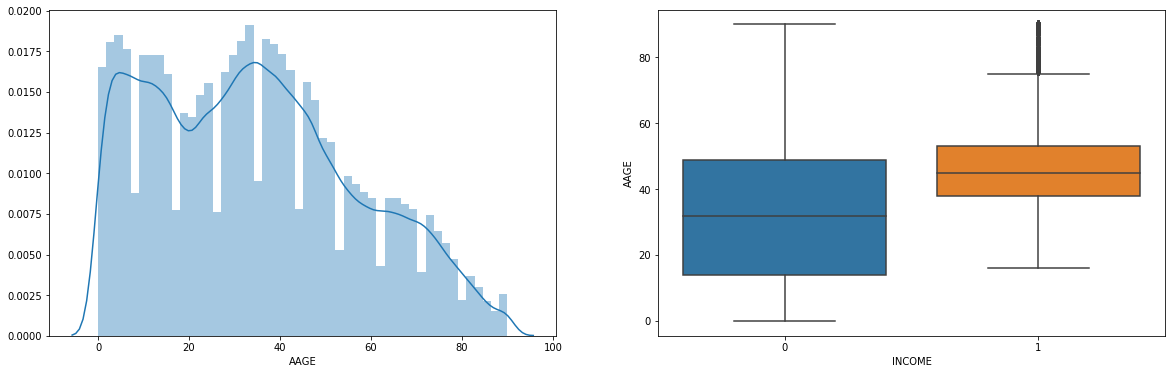

In [27]:
fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.distplot(df.AAGE,ax=a)
sns.boxplot(y='AAGE',x='INCOME',data=df,ax=b)

The age seems to have an impact on the income as the distribution between the two groups is not the same: instances who earn more than 50K/year are older (on average) than those who earn less than this threshold value.

In [28]:
corr(["AAGE", "INCOME"], df)

,AAGE,INCOME
AAGE,1,0.136313
INCOME,0.136313,1


The age of the individual seems to be a bit correlated with the income.

In order to take into account non-linear effects we can create a variable `AAGE2` such that $AAGE2= AAGE^2$. Indeed, by doing this we make possible the fact increasing the age of 1 year does not have the same effect on the income whether the invidual is young or old.

In [29]:
df["AAGE2"] = df["AAGE"]*df["AAGE"]

### `ADTIND` : industry code

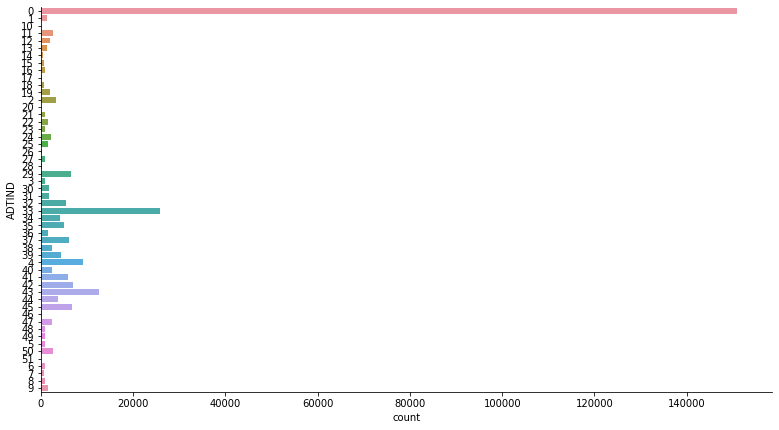

In [30]:
sns.catplot(y='ADTIND', kind='count' ,data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

`ADTIND` = 0 and `ADTIND` = 33 are the most represented ones, hence we shall create two dummies for those ones. However the modality 0 is over represented, it can cause some algorithm optimization troubles while trying to find the optimum (maximum likelihood, loss function optimization *etc*.)

In [31]:
df["ADTIND33"] = np.where(df["ADTIND"] == "33", 1, 0)

print(pd.crosstab(df.ADTIND33, df.INCOME))

INCOME         0      1
ADTIND33               
0         256105  17398
1          24612   1170


In [32]:
corr(["ADTIND33", "INCOME"], df)

,ADTIND33,INCOME
ADTIND33,1,-0.021205
INCOME,-0.021205,1


In [33]:
df = df.drop(columns = "ADTIND") #We drop the original ADTIND variable

### `ADTOCC` : occupation code

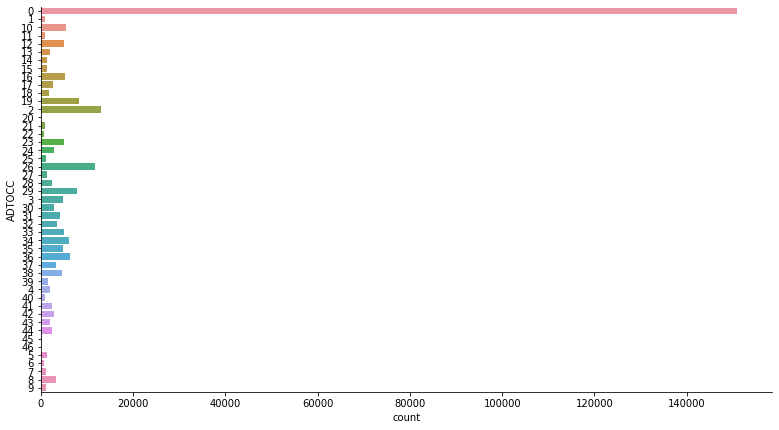

In [34]:
sns.catplot(y='ADTOCC', kind='count' ,data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

The modality 0 is over-represented in the data, it can cause prediction model to fail when optimizing the loss function. Hence we should not create a dummy for the modality 0, we can try with the other modalities the most represented, 2 and 26.

In [35]:
df["ADTOCC2"] = np.where(df["ADTOCC"] == "2", 1, 0)
df["ADTOCC26"] = np.where(df["ADTOCC"] == "26", 1, 0)

In [36]:
corr(["ADTOCC2", "ADTOCC26", "INCOME"], df)

,ADTOCC2,ADTOCC26,INCOME
ADTOCC2,1,-0.0431767,0.230599
ADTOCC26,-0.0431767,1,-0.0307961
INCOME,0.230599,-0.0307961,1


`ADTOCC2` is highly correlated with `INCOME` so we can keep it and delete `ADTOCC26` and `ADTOCC`. 

In [37]:
df = df.drop(columns = ["ADTOCC", "ADTOCC26"])

### `AHGA`: education

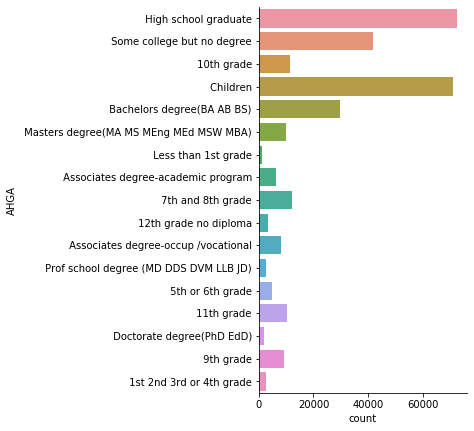

In [38]:
sns.catplot(y='AHGA', kind='count' ,data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

We are going to create specific categories:bachelor's degree (or associates), master's or higher, some college but no degree, (else).

In [39]:
df.AHGA.unique()

array([' High school graduate', ' Some college but no degree',
       ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)',
       ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade',
       ' Associates degree-academic program', ' 7th and 8th grade',
       ' 12th grade no diploma', ' Associates degree-occup /vocational',
       ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade',
       ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade',
       ' 1st 2nd 3rd or 4th grade'], dtype=object)

In [40]:
df["high_school"] = np.where(df["AHGA"] == ' High school graduate', 1, 0)
df["bachelor"] = np.where(df["AHGA"].isin([' Bachelors degree(BA AB BS)',
                                          ' Associates degree-academic program']), 1, 0)
df["masters"] = np.where(df["AHGA"].isin([" Masters degree(MA MS MEng MEd MSW MBA)",
                                           " Doctorate degree(PhD EdD)",
                                          " Prof school degree (MD DDS DVM LLB JD)"]),1, 0)
df["some_college"] = np.where(df["AHGA"] == ' Some college but no degree',1, 0)

In [41]:
corr(["high_school", "bachelor", "masters", "some_college", "INCOME"], df)

,high_school,bachelor,masters,some_college,INCOME
high_school,1,-0.20981,-0.127176,-0.22784,-0.0526291
bachelor,-0.20981,1,-0.0833839,-0.149385,0.179386
masters,-0.127176,-0.0833839,1,-0.0905494,0.297839
some_college,-0.22784,-0.149385,-0.0905494,1,0.00149046
INCOME,-0.0526291,0.179386,0.297839,0.00149046,1


`some_college` and `high_school` are not too much correlated with `INCOME` compared to the others with just created, we are going to drop them as well as `AHGA`.

In [42]:
df = df.drop(columns = ["some_college", "high_school", "AHGA"])

### `AHRSPAY`: wage per hour

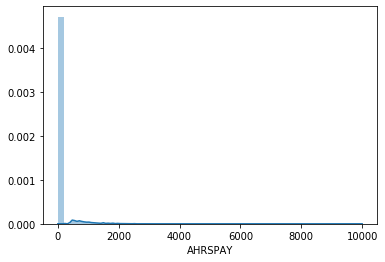

In [43]:
sns.distplot(df.AHRSPAY)

Nearly all observations are equal to 0, hence this variable is not useful.

In [44]:
df = df.drop(columns = "AHRSPAY")

### `AMARITL` : marital status

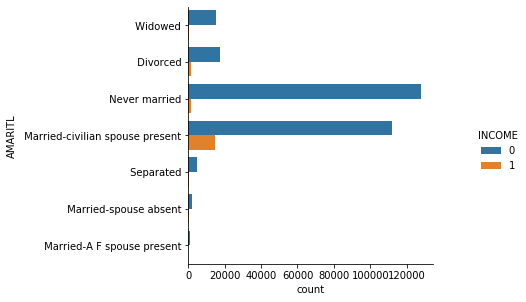

In [45]:
sns.catplot(y='AMARITL', kind='count', hue = "INCOME" ,data=df)
fig = plt.gcf()
fig.set_size_inches(10, 4)

We can create dummies for the the top 2 categories the most represented.

In [46]:
df.AMARITL.unique()

array([' Widowed', ' Divorced', ' Never married',
       ' Married-civilian spouse present', ' Separated',
       ' Married-spouse absent', ' Married-A F spouse present'],
      dtype=object)

In [47]:
df["never_married"] = np.where(df["AMARITL"] == ' Never married', 1, 0)
df["married"] = np.where(df["AMARITL"] == ' Married-civilian spouse present', 1, 0)

In [48]:
corr(["never_married", "married", "INCOME"], df)

,never_married,married,INCOME
never_married,1,-0.746974,-0.17835
married,-0.746974,1,0.185217
INCOME,-0.17835,0.185217,1


In [49]:
df = df.drop(columns = "AMARITL")

### `AMJIND` : major industry code

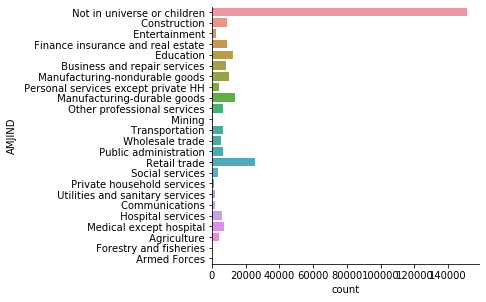

In [50]:
sns.catplot(y='AMJIND', kind='count' ,data=df)
fig = plt.gcf()
fig.set_size_inches(10, 4)

There is a confusion here because "Not in universe or children" means we do not know if it is a missing value or a children, the other categories are not too much represented.

In [51]:
df["child_na"] = np.where(df["AMJIND"] == " Not in universe or children", 1, 0)

corr(["child_na", "INCOME"], df)

,child_na,INCOME
child_na,1,-0.222046
INCOME,-0.222046,1


It is correlated, so we can keep it as it is.

In [52]:
df = df.drop(columns = "AMJIND")

### `ARACE` : race

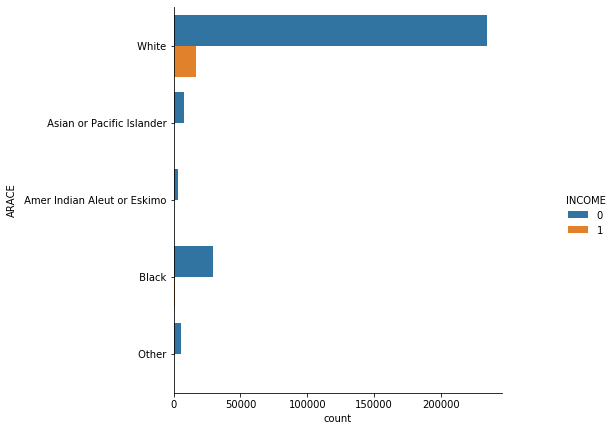

In [53]:
sns.catplot(y='ARACE', kind='count', hue = "INCOME", data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [54]:
pd.crosstab(df.ARACE, df.INCOME).apply(lambda r: r/r.sum(), axis=1)

INCOME,0,1
ARACE,,
Amer Indian Aleut or Eskimo,0.977746,0.022254
Asian or Pacific Islander,0.928326,0.071674
Black,0.973247,0.026753
Other,0.977338,0.022662
White,0.932580,0.067420


We can see a little difference of proportion for Asian and White, we can create dummies for those modalities.

In [55]:
df["asian"] = np.where(df["ARACE"] == " Asian or Pacific Islander", 1, 0)
df["white"] = np.where(df["ARACE"] == " White", 1, 0)

In [56]:
df = df.drop(columns = "ARACE")

### `AREORGN` : hispanic origin

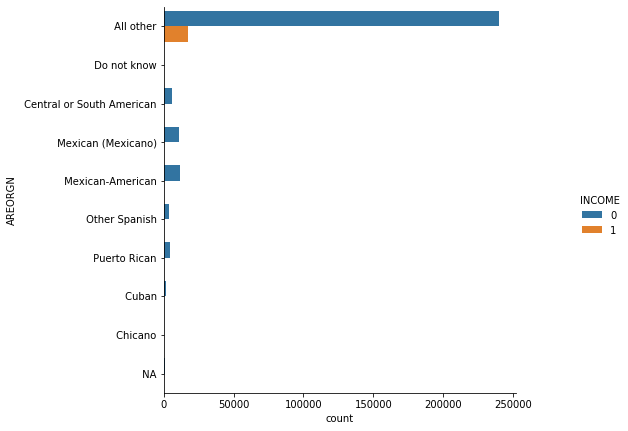

In [57]:
sns.catplot(y='AREORGN', kind='count', hue = "INCOME",data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [58]:
pd.crosstab(df.AREORGN, df.INCOME).apply(lambda r: r/r.sum(), axis=1)

INCOME,0,1
AREORGN,,
All other,0.931645,0.068355
Central or South American,0.978409,0.021591
Chicano,0.970464,0.029536
Cuban,0.939150,0.060850
Do not know,0.968610,0.031390
Mexican (Mexicano),0.987282,0.012718
Mexican-American,0.979470,0.020530
NA,0.942924,0.057076
Other Spanish,0.968348,0.031652


In [59]:
sum(df.AREORGN == " NA")

1279

We did not see this type of missing value, hence we are going to treat it as if it was "All other".

In [60]:
df["not_hispanic"] = np.where(df["AREORGN"].isin([" NA", " All other"]), 1, 0)
df = df.drop(columns = "AREORGN")

### `ASEX` : gender

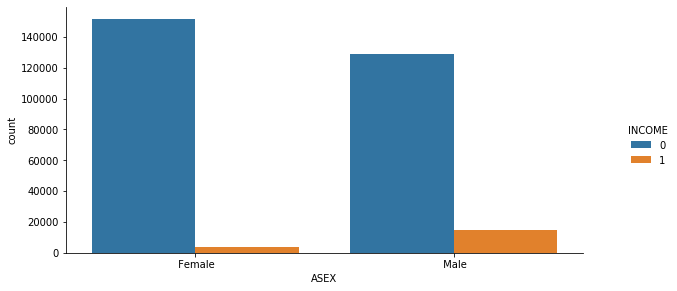

In [61]:
sns.catplot(x='ASEX', kind='count', hue = "INCOME",data=df)
fig = plt.gcf()
fig.set_size_inches(10, 4)

Men seems to have a higher income than women.

In [62]:
df["man"] = np.where(df["ASEX"] == ' Male', 1, 0)
df = df.drop(columns = "ASEX")

In [63]:
corr(["man", "INCOME"], df)

,man,INCOME
man,1,0.157937
INCOME,0.157937,1


The variable `man` is positively correlated with `INCOME`.

### `AWKSTAT` : full or part time employment stat

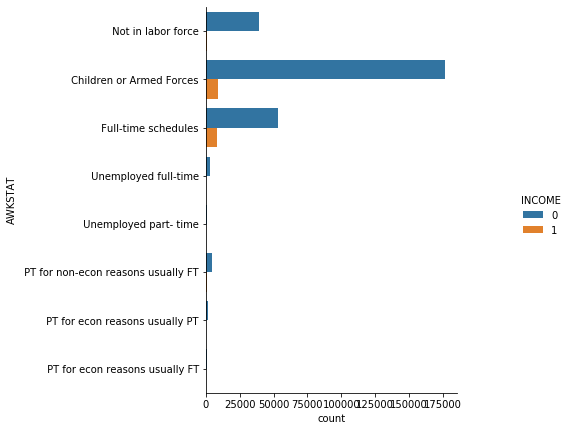

In [64]:
sns.catplot(y='AWKSTAT', kind='count', hue = "INCOME",data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

We visually see that having a full-time job or being a children/ belonging toarmed forces, have a positive impact on the income.

In [65]:
df["full_time"] = np.where(df["AWKSTAT"] == ' Full-time schedules', 1, 0)
df["armed_forces_child"] = np.where(df["AWKSTAT"] == ' Children or Armed Forces', 1, 0)
df = df.drop(columns = "AWKSTAT")

corr(["full_time" ,"armed_forces_child", "INCOME"], df)

,full_time,armed_forces_child,INCOME
full_time,1,-0.647182,0.147149
armed_forces_child,-0.647182,1,-0.0785783
INCOME,0.147149,-0.0785783,1


### `CAPGAIN`  & `CAPLOSS` : capital gains & losses

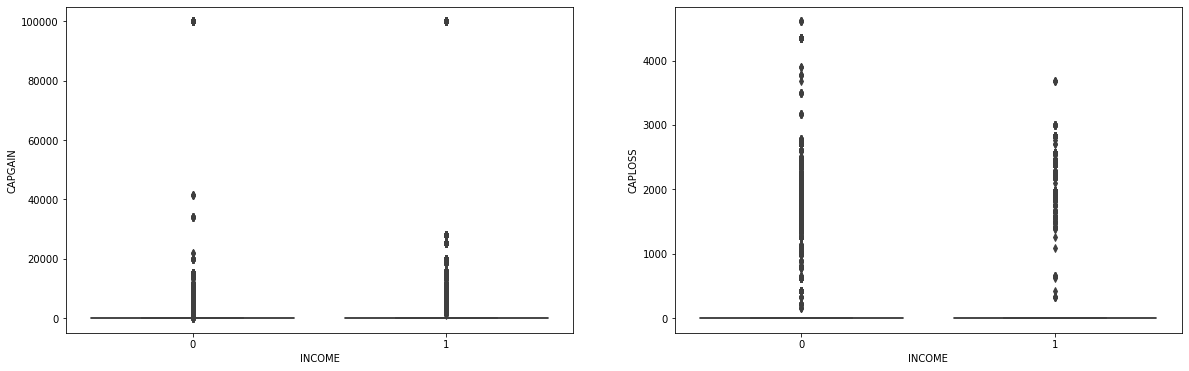

In [66]:
fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.boxplot(y='CAPGAIN',x='INCOME',data=df,ax=a)
sns.boxplot(y='CAPLOSS',x='INCOME',data=df,ax=b)

We ought transform their scale to the log in order to have a better visualization of those variables.

In [67]:
print("Minimum values of CAPGAIN and CAPLOSS are", min(df.CAPGAIN),"and", min(df.CAPLOSS))

Minimum values of CAPGAIN and CAPLOSS are 0 and 0


As those variables can take 0 as a value, we can use the transformation $x' = log(1+x)$ to avoid the variable tending to $-\infty$.

In [68]:
df["log_capgain"] = np.log1p(df["CAPGAIN"])
df["log_caploss"] = np.log1p(df["CAPLOSS"])
df = df.drop(columns = ["CAPGAIN", "CAPLOSS"])

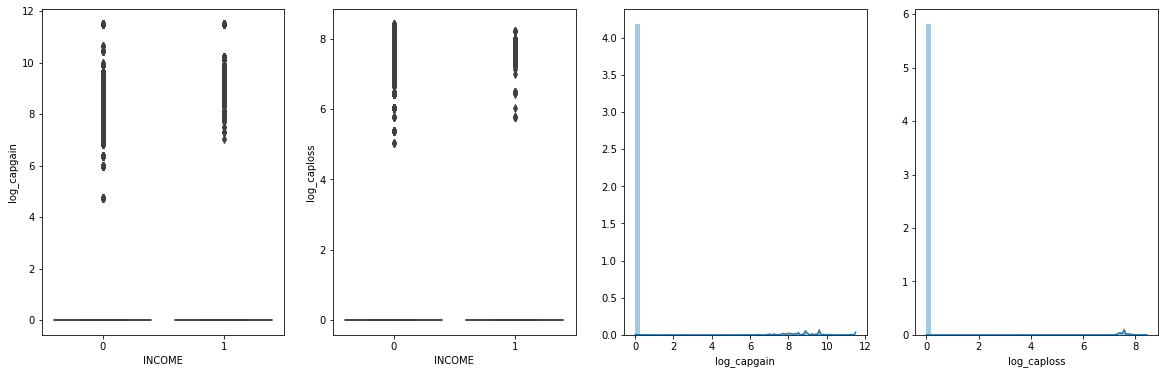

In [69]:
fig, (a,b,c,d)= plt.subplots(1,4,figsize=(20,6))
sns.boxplot(y='log_capgain',x='INCOME',data=df,ax=a)
sns.boxplot(y='log_caploss',x='INCOME',data=df,ax=b)
sns.distplot(df['log_capgain'],ax=c)
sns.distplot(df['log_caploss'],ax=d)

In [70]:
corr(["log_capgain", "log_caploss", "INCOME"], df)

,log_capgain,log_caploss,INCOME
log_capgain,1,-0.02739,0.240358
log_caploss,-0.02739,1,0.140926
INCOME,0.240358,0.140926,1


`log_capgain` and `log_caploss` are positively with `INCOME`. It means that people who make gains or losses, are the ones who own capital. No matter if they win or lose, if they realize gains/losses it means they own capital, so it has a positive impact on the income (at least it is correlated).

### `DIVVAL` : dividends from stocks

In [71]:
df.DIVVAL.describe()

count    299285.000000
mean        195.851259
std        1937.847082
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       99999.000000
Name: DIVVAL, dtype: float64

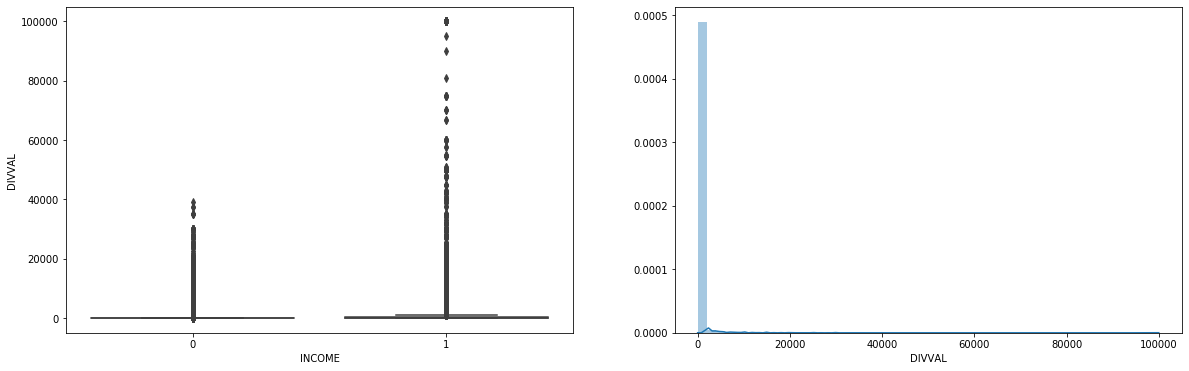

In [72]:
sns.fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.boxplot(y='DIVVAL',x='INCOME',data=df,ax=a)
sns.distplot(df.DIVVAL,ax=b)

Even if most observations present `DIVVAL` = 0, the boxplot shows us that people having an income higher than 50K/year can have very high dividends. We should take care of outliers, but first let's see if there are outliers in both train set and test set. 

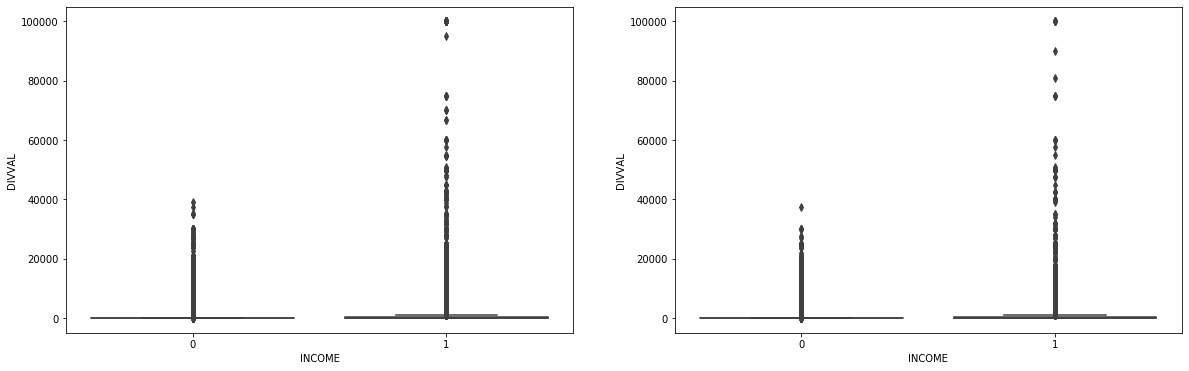

In [73]:
sns.fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.boxplot(y='DIVVAL',x='INCOME',data=df[df.testing == 0],ax=a)
sns.boxplot(y='DIVVAL',x='INCOME',data=df[df.testing == 1],ax=b)

Same configuration, we should not erase those values, the model has to be able to predict them. Again, we can change the variable with the $log(1+x)$ transformation.

We can add that the log transformation avoid for heteroskedasticity.

In [74]:
df["log_divval"] = np.log1p(df["DIVVAL"])

corr(["log_divval", "DIVVAL", "INCOME"], df)

,log_divval,DIVVAL,INCOME
log_divval,1,0.449697,0.286286
DIVVAL,0.449697,1,0.178462
INCOME,0.286286,0.178462,1


`log_divval` presents better results in terms of correlation with `INCOME`.

In [75]:
df = df.drop(columns = "DIVVAL")

### `FILESTAT` : tax filer status

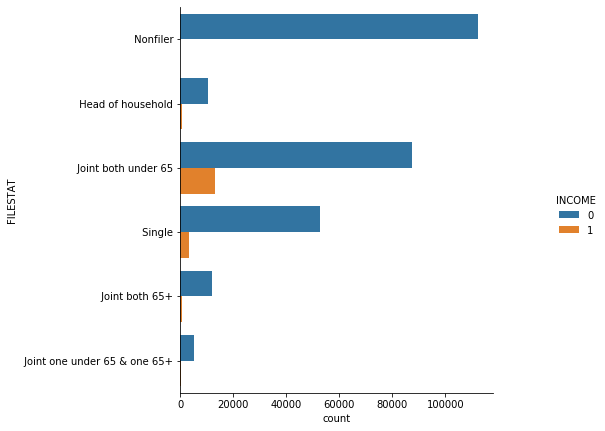

In [76]:
sns.catplot(y='FILESTAT', kind='count', hue = "INCOME",data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [77]:
pd.crosstab(df.FILESTAT, df.INCOME).apply(lambda r: r/r.sum(), axis=1)

INCOME,0,1
FILESTAT,,
Head of household,0.940803,0.059197
Joint both 65+,0.947629,0.052371
Joint both under 65,0.868119,0.131881
Joint one under 65 & one 65+,0.918891,0.081109
Nonfiler,0.999555,0.000445
Single,0.939412,0.060588


Categories "Joint both under 65", "Joint one under 65 & one 65+", "Single" and "Nonfiler" have particular patterns, we can create dummies for each of them. 

In [78]:
df["under65"] = np.where(df["FILESTAT"] == ' Joint both under 65', 1, 0)
df["over_under65"] = np.where(df["FILESTAT"] == ' Joint one under 65 & one 65+', 1, 0)
df["single"] = np.where(df["FILESTAT"] == ' Single', 1, 0)
df["nonfiler"] = np.where(df["FILESTAT"] == ' Nonfiler', 1, 0)

In [79]:
corr(["under65", "over_under65", "single", "nonfiler", "INCOME"], df)

,under65,over_under65,single,nonfiler,INCOME
under65,1,-0.100685,-0.343483,-0.553551,0.206556
over_under65,-0.100685,1,-0.0679408,-0.109492,0.0111547
single,-0.343483,-0.0679408,1,-0.373528,-0.00290067
nonfiler,-0.553551,-0.109492,-0.373528,1,-0.198113
INCOME,0.206556,0.0111547,-0.00290067,-0.198113,1


`over_under65` and `single` are nearly not correlated with `INCOME`, we can delete them as well as `FILESTAT`.

In [80]:
df = df.drop(columns = ["over_under65", "single", "FILESTAT"])

### `HHDFMX` : detailed household and family stat

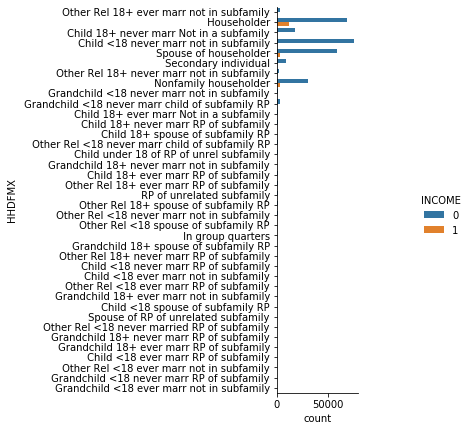

In [81]:
sns.catplot(y='HHDFMX', kind='count', hue = "INCOME",data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

Given the number of possibilities, we will only keep the most represented ones.

In [82]:
df["spouse_of"] = np.where(df["HHDFMX"] == ' Spouse of householder', 1, 0)
df["non_family"] = np.where(df["HHDFMX"] == ' Nonfamily householder', 1, 0)
df["householder"] = np.where(df["HHDFMX"] == ' Householder', 1, 0)
df["child_b18"] = np.where(df["HHDFMX"] == " Child <18 never marr not in subfamily", 1, 0)
df["child_a18"] = np.where(df["HHDFMX"] == " Child 18+ never marr Not in a subfamily", 1, 0)

df = df.drop(columns = "HHDFMX")

corr(["spouse_of", "non_family", "householder", "child_b18", "child_a18", "INCOME"], df)

,spouse_of,non_family,householder,child_b18,child_a18,INCOME
spouse_of,1,-0.181987,-0.309684,-0.297477,-0.130396,-0.015016
non_family,-0.181987,1,-0.214166,-0.205724,-0.0901768,0.0258622
householder,-0.309684,-0.214166,1,-0.350077,-0.153452,0.214115
child_b18,-0.297477,-0.205724,-0.350077,1,-0.147404,-0.149077
child_a18,-0.130396,-0.0901768,-0.153452,-0.147404,1,-0.0584129
INCOME,-0.015016,0.0258622,0.214115,-0.149077,-0.0584129,1


### `HHDREL` : detailed household summary in household

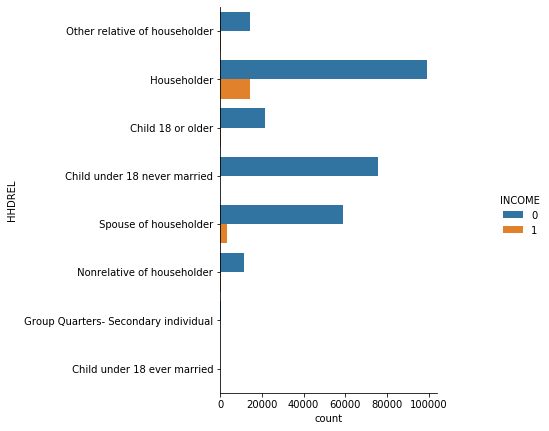

In [83]:
sns.catplot(y='HHDREL', kind='count', hue = "INCOME", data = df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [84]:
pd.crosstab(df.HHDREL, df.INCOME).apply(lambda r: r/r.sum(), axis=1)

INCOME,0,1
HHDREL,,
Child 18 or older,0.991548,0.008452
Child under 18 ever married,1.000000,0.000000
Child under 18 never married,0.999973,0.000027
Group Quarters- Secondary individual,0.989305,0.010695
Householder,0.872472,0.127528
Nonrelative of householder,0.969071,0.030929
Other relative of householder,0.990848,0.009152
Spouse of householder,0.945034,0.054966


In [85]:
df.HHDREL.unique()

array([' Other relative of householder', ' Householder',
       ' Child 18 or older', ' Child under 18 never married',
       ' Spouse of householder', ' Nonrelative of householder',
       ' Group Quarters- Secondary individual',
       ' Child under 18 ever married'], dtype=object)

In [86]:
df["household2"] = np.where(df["HHDREL"] == ' Householder', 1, 0)

corr(["household2", "INCOME"], df)

,household2,INCOME
household2,1,0.212062
INCOME,0.212062,1


In [87]:
df = df.drop(columns = "HHDREL")

### `MARSUPWT` : instance weight

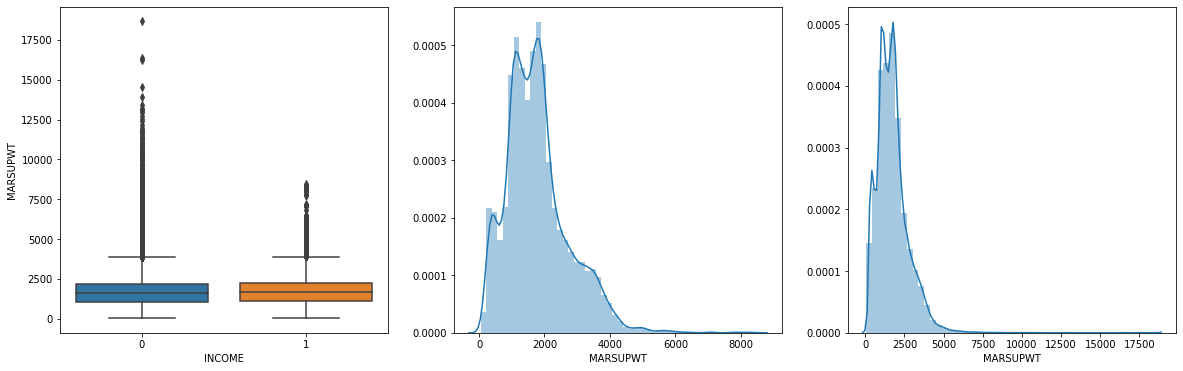

In [88]:
sns.fig, (a,b,c)= plt.subplots(1,3,figsize=(20,6))
sns.boxplot(y='MARSUPWT',x='INCOME',data=df,ax=a)
sns.distplot(df[df.INCOME == 1].MARSUPWT,ax=b)
sns.distplot(df[df.INCOME == 0].MARSUPWT,ax=c)

In [89]:
corr(["MARSUPWT", "INCOME"], df)

,MARSUPWT,INCOME
MARSUPWT,1,0.0129932
INCOME,0.0129932,1


It seems there is no difference between the group earning more than 50K/year and those who earn less than this threshold.

In [90]:
df = df.drop(columns = "MARSUPWT")

### `MIGSAME` : live in this house 1 year ago

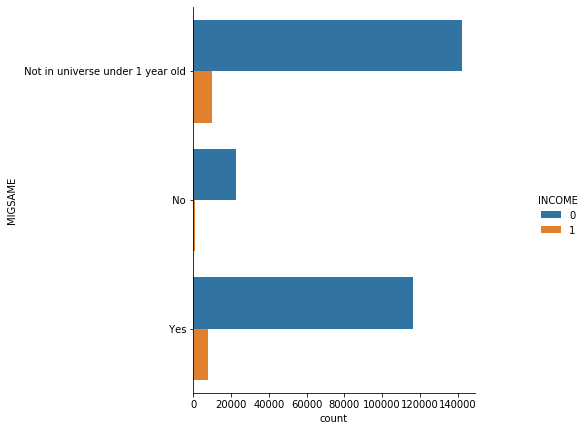

In [91]:
sns.catplot(y='MIGSAME', kind='count', hue = "INCOME", data = df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [92]:
df["migsame_b1"] = np.where(df["MIGSAME"] == ' Not in universe under 1 year old', 1, 0)
df["migsame_yes"] = np.where(df["MIGSAME"] == ' No', 1, 0)

corr(["migsame_b1", "migsame_yes", "INCOME"], df)

,migsame_b1,migsame_yes,INCOME
migsame_b1,1,-0.296084,0.0123876
migsame_yes,-0.296084,1,-0.0262227
INCOME,0.0123876,-0.0262227,1


This variable is not correlated with `INCOME` we can delete it.

In [93]:
df = df.drop(columns = ["migsame_b1", "migsame_yes", "MIGSAME"])

### `NOEMP` : num persons worked for employer

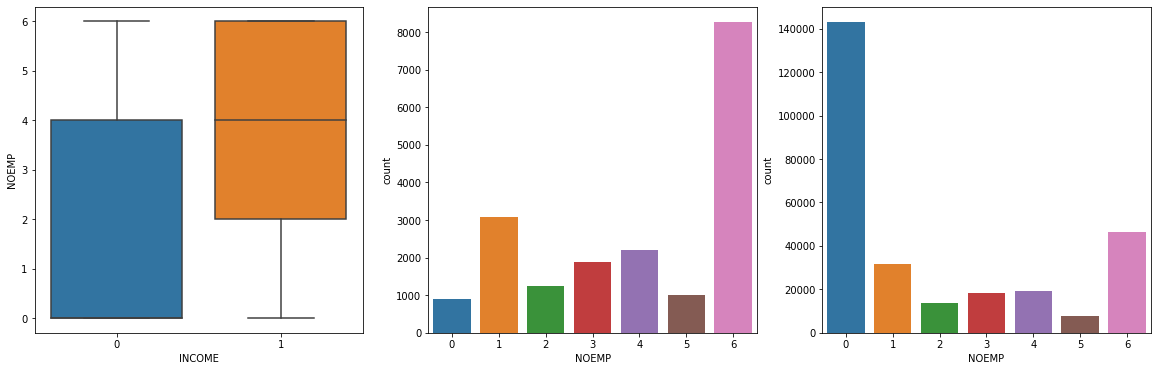

In [94]:
sns.fig, (a,b,c)= plt.subplots(1,3,figsize=(20,6))
sns.boxplot(y='NOEMP',x='INCOME',data=df,ax=a)
sns.countplot(df[df.INCOME == 1].NOEMP, ax=b)
sns.countplot(df[df.INCOME == 0].NOEMP, ax=c)

Above, we first boxplots of the variable `NOEMP`, we see that the distribution is not the same whether the individual earns more than 50K/year or not: not the same median, mean, quantiles, *etc*. The next two plots are barplots, the first shows count for the different values that `NOEMP` can take when `INCOME` = 1, the second one shows it when `INCOME` = 0. We clearly notice that if `NOEMP` = 6, people presenting an income higher than 50K/year are over-represented. It can be seen the opposite effect when `NOEMP` = 0.

As this variable seems to have an effect on `INCOME`, as for the variable `AAGE`, we can set it to the square in order to detect non-linear effects.

In [95]:
df["NOEMP2"] = df["NOEMP"]*df["NOEMP"]

In [96]:
corr(["NOEMP", "NOEMP2", "INCOME"], df)

,NOEMP,NOEMP2,INCOME
NOEMP,1,0.970813,0.224148
NOEMP2,0.970813,1,0.207696
INCOME,0.224148,0.207696,1


### `PEFNTVTY`,  `PEMNTVTY` & `PENATVTY` : country of birth of the father, mother and self

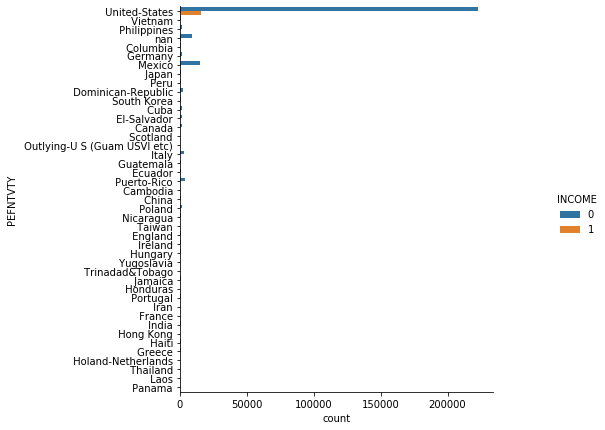

In [97]:
sns.catplot(y='PEFNTVTY', kind='count', hue = "INCOME", data = df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

Those variables inform us about the country of birth of the individual, we notice there are style missing value. But in this case it can be used as a supplementary information.

In order to feed the model more later one, we can dummies variable indicating whether the individual has the same country of birth of his/her parents.

We will also create dummies indicating if the individual is born Mexico or NA. Those are the two most represented modalities after USA, which is over-represented, thus this latter is not useful. The plots for the country of birth of the mother or the individual show the same pattern in terms of countries represented: USA, Mexico and NA are the main ones.

In [98]:
#Father:
df["father_mexico"] = np.where(df["PEFNTVTY"] == ' Mexico', 1, 0)
df["father_nan"] = np.where(df["PEFNTVTY"] == 'nan', 1, 0)
#Mother:
df["mother_mexico"] = np.where(df["PEMNTVTY"] == ' Mexico', 1, 0)
df["mother_nan"] = np.where(df["PEMNTVTY"] == 'nan', 1, 0)
#Self:
df["self_mexico"] = np.where(df["PENATVTY"] == ' Mexico', 1, 0)
df["self_nan"] = np.where(df["PENATVTY"] == 'nan', 1, 0)

#Same country as the father:
df["same_country_father"] = np.where(df["PENATVTY"] == df["PEFNTVTY"], 1, 0)
#Same country as the mother:
df["same_country_mother"] = np.where(df["PENATVTY"] == df["PEMNTVTY"], 1, 0)
#Same country as both father and mother:
df["same_country_both"] = np.where((df["PENATVTY"] == df["PEMNTVTY"])&(df["PENATVTY"] == df["PEFNTVTY"]), 1, 0)

### `PRCITSHP`: citizenship

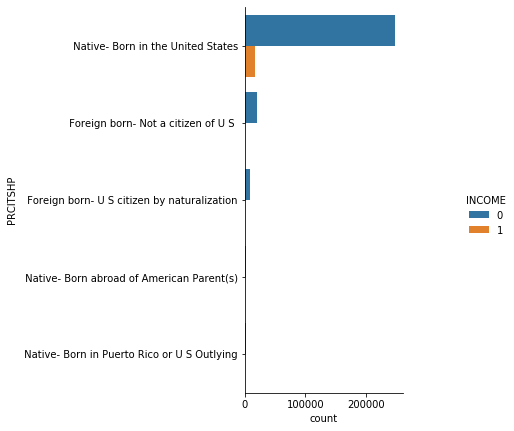

In [99]:
sns.catplot(y='PRCITSHP', kind='count', hue = "INCOME", data = df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

Intuitively, we can indicate, for US citizen (most of the cases), if they are also born the USA or not. It may have an impact, positive or negative, on the income.

As before, people born in the USA are over-represented so we shall not create a dummy for them.

In [100]:
df["birth_citizen"] = np.where((df["PRCITSHP"] == ' Native- Born in the United States')&
                               (df["PENATVTY"] == ' United-States'), 1, 0)

#We can drop the variables now:
df = df.drop(columns = ["PEFNTVTY", "PEMNTVTY", "PENATVTY", "PRCITSHP"])

### `SEOTR` : own business or self employed

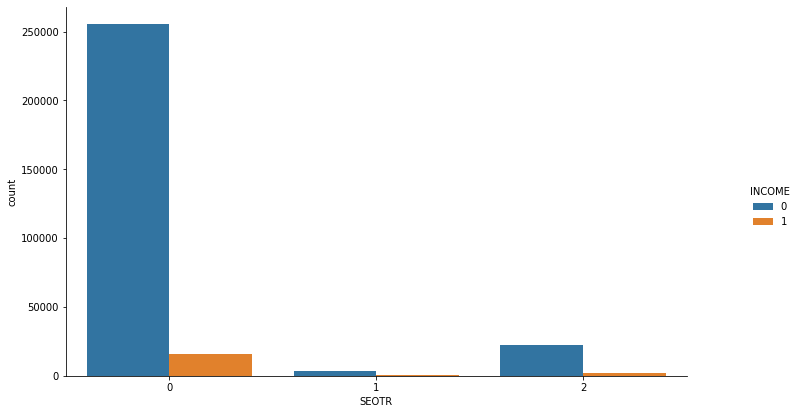

In [101]:
sns.catplot(x='SEOTR', kind='count', hue = "INCOME", data = df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [102]:
corr(["SEOTR", "INCOME"], df)

,SEOTR,INCOME
SEOTR,1,0.0413227
INCOME,0.0413227,1


Even if this variable does not seem correlated with `INCOME` we may keep it in the data set as it would be logical that it may affect the income in a sense. We can create a dummy variable: 1 if `SEOTR` = 0, 0 otherwise.

In [103]:
df["SEOTR0"] = np.where(df["SEOTR"] == 0, 1, 0)

df = df.drop(columns = "SEOTR")

### `VETYN` : veteran benefits

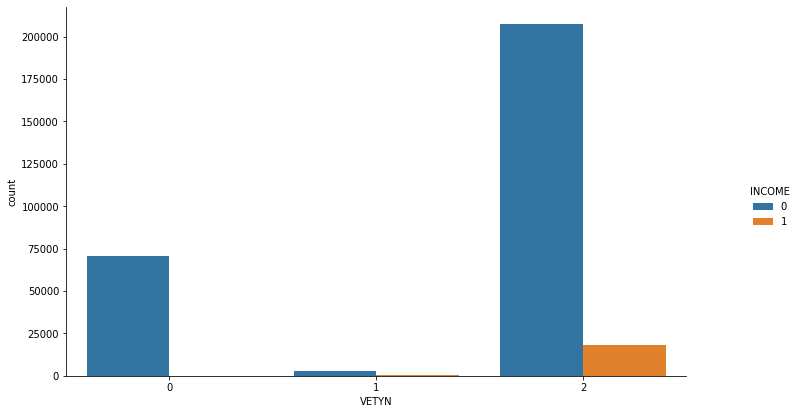

In [104]:
sns.catplot(x='VETYN', kind='count', hue = "INCOME", data = df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [105]:
corr(["VETYN", "INCOME"], df)

,VETYN,INCOME
VETYN,1,0.140445
INCOME,0.140445,1


This variable seems to be positively correlated with `INCOME` so we can keep it as it is ! (numerically and not as a categorical variable)

### `WKSWORK` : weeks worked in a year

In [106]:
df.WKSWORK.describe()

count    299285.000000
mean         23.178375
std          24.404016
min           0.000000
25%           0.000000
50%           8.000000
75%          52.000000
max          52.000000
Name: WKSWORK, dtype: float64

The minimum is 0 and the maximum is 52, no irregularites here (52 weeks at maximum in a year).

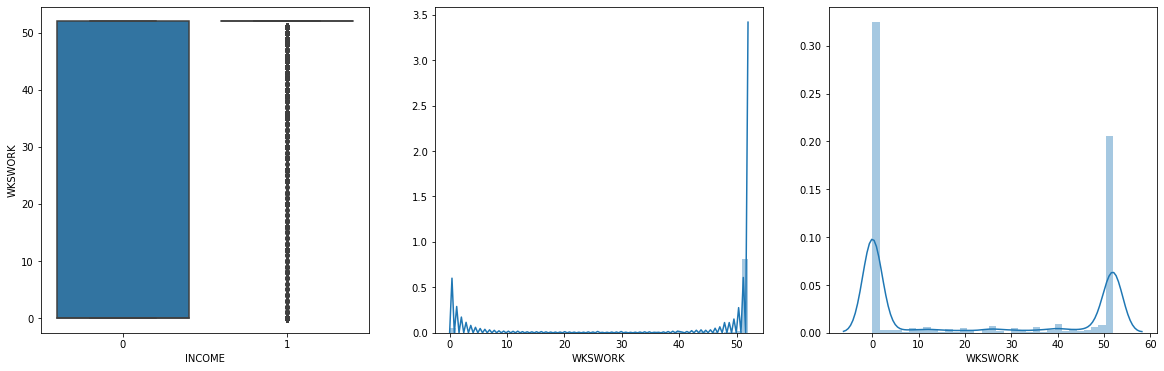

In [107]:
sns.fig, (a,b,c)= plt.subplots(1,3,figsize=(20,6))
sns.boxplot(y='WKSWORK',x='INCOME',data=df,ax=a)
sns.distplot(df[df.INCOME == 1].WKSWORK,ax=b)
sns.distplot(df[df.INCOME == 0].WKSWORK,ax=c)

In [108]:
print(df[df.INCOME == 0].WKSWORK.describe())

count    280717.000000
mean         21.532529
std          24.110453
min           0.000000
25%           0.000000
50%           0.000000
75%          52.000000
max          52.000000
Name: WKSWORK, dtype: float64


In [109]:
print(df[df.INCOME == 1].WKSWORK.describe())

count    18568.000000
mean        48.060804
std         12.279703
min          0.000000
25%         52.000000
50%         52.000000
75%         52.000000
max         52.000000
Name: WKSWORK, dtype: float64


We easily notice that people earning more than 50K/year work so much more than people under that threshold. We can check it both graphically with the boxplot and the densities but also numerically:

`INCOME` = 0 : $\begin{cases}
\text{weeks worked on average} = 21.76 \\
\text{median} = 0 
\end{cases}$

`INCOME` = 1 : $\begin{cases}
\text{weeks worked on average} = 48.01 \\
\text{median} = 52
\end{cases}$

Two big informations there:

1- Among people earning less than 50K/year, at least 50% of them did not work at all during the year

2- Among people earning more than 50K/year, at least 75% of them worked every week. 

We can set this variable to the square in order to take into account non-linear effects.

In [110]:
df["WKSWORK2"] = df["WKSWORK"]*df["WKSWORK"]

In [111]:
corr(["WKSWORK", "INCOME"],df)

,WKSWORK,INCOME
WKSWORK,1,0.262229
INCOME,0.262229,1


As expected it is pretty much correlated with the dependent variable.

### `YEAR` : year

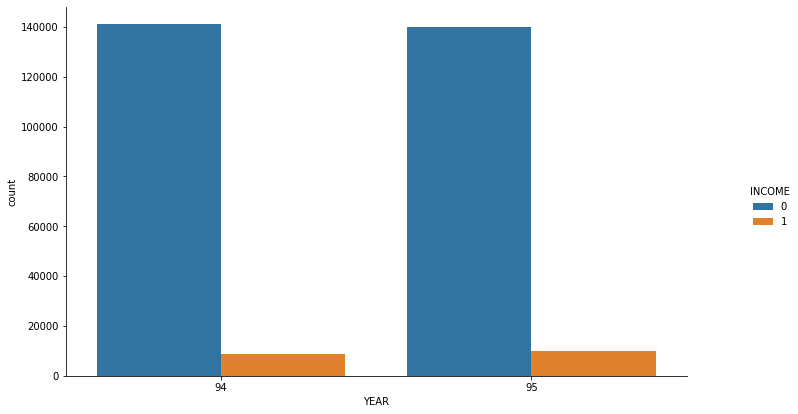

In [112]:
sns.catplot(x='YEAR', kind='count', hue = "INCOME", data = df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

In [113]:
corr(["YEAR", "INCOME"], df)

,YEAR,INCOME
YEAR,1,0.0162343
INCOME,0.0162343,1


There is no big difference in terms of income between the year 1994 and 1995, we can delete this time variable.

In [114]:
df = df.drop(columns = "YEAR")

# 4 Over-sampling and scaling data 

## 4.1 Over-sampling

It is now time to start reshaping the data to make predictions !

A good practice would be to first split `df` into `X_fit`, `y_fit`, `X_test` and `y_test`.

In [115]:
X_fit = df.query('testing == 0').drop(columns = ["INCOME", "testing"])
y_fit = df.query('testing == 0')['INCOME']
X_test = df.query('testing == 1').drop(columns = ["INCOME", "testing"])
y_test = df.query('testing == 1')['INCOME']

X_fit.head()

,AAGE,NOEMP,VETYN,WKSWORK,AAGE2,ADTIND33,ADTOCC2,bachelor,masters,never_married,married,child_na,asian,white,not_hispanic,man,full_time,armed_forces_child,log_capgain,log_caploss,log_divval,under65,nonfiler,spouse_of,non_family,householder,child_b18,child_a18,household2,NOEMP2,father_mexico,father_nan,mother_mexico,mother_nan,self_mexico,self_nan,same_country_father,same_country_mother,same_country_both,birth_citizen,SEOTR0,WKSWORK2
0,73,0,2,0,5329,0,0,0,0,0,0,1,0,1,1,0,0,0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
1,58,1,2,52,3364,0,0,0,0,0,0,0,0,1,1,1,0,1,0.0,0.0,0.0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,2704
2,18,0,2,0,324,0,0,0,0,1,0,1,1,0,1,0,0,0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0
3,9,0,0,0,81,0,0,0,0,1,0,1,0,1,1,0,0,1,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
4,10,0,0,0,100,0,0,0,0,1,0,1,0,1,1,0,0,1,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0


Checking things have be done correctly:

In [116]:
assert all(X_fit.columns == X_test.columns)
assert X_fit.isnull().sum().sum() == 0
assert X_test.isnull().sum().sum() == 0
assert len(X_fit) == len(y_fit)
assert len(X_test) == len(y_test)

No error so it is fine :)

In order to have more data we can apply an over-sampling methode, SMOTE package will do the job. Furthermore it allows to have a balanced data (equilibrium between the number of individual having `INCOME`= 1 and `INCOME` = 0)

In [117]:
os = SMOTE(random_state=0)

columns = X_fit.columns
X_fit_os,y_fit_os = os.fit_sample(X_fit, y_fit)
X_fit_os = pd.DataFrame(data=X_fit_os, columns= columns)
y_fit_os= pd.DataFrame(data=y_fit_os,columns=['INCOME'])

# Checking proportions:
print("Number of individuals in oversampled data:",len(X_fit_os))
print("Number of people earning more than 50K/year in oversampled data:",sum(y_fit_os.INCOME == 1))
print("Number of people earning less than 50K/year in oversampled data:",sum(y_fit_os.INCOME == 0))
print("Proportion of people earning more than 50K/year in oversampled data:",sum(y_fit_os.INCOME == 1)/len(X_fit_os))
print("Proportion of people earning less than 50K/year  in oversampled data:",sum(y_fit_os.INCOME == 0)/len(X_fit_os))

Number of individuals in oversampled data: 374282
Number of people earning more than 50K/year in oversampled data: 187141
Number of people earning less than 50K/year in oversampled data: 187141
Proportion of people earning more than 50K/year in oversampled data: 0.5
Proportion of people earning less than 50K/year  in oversampled data: 0.5


The data has been over-sampled and is now balanced concerning the dependent variable.

## 4.2 Scaling data

To increase algorithms precision, we can scale the data, we have to take care to only scale quantitative data. Indeed, there is no reason to scale dummies. We can use a scaler robust to outliers such like RobustScaler. It is even more efficient as we over-sampled before.

In [118]:
X_fit_os.head()

,AAGE,NOEMP,VETYN,WKSWORK,AAGE2,ADTIND33,ADTOCC2,bachelor,masters,never_married,married,child_na,asian,white,not_hispanic,man,full_time,armed_forces_child,log_capgain,log_caploss,log_divval,under65,nonfiler,spouse_of,non_family,householder,child_b18,child_a18,household2,NOEMP2,father_mexico,father_nan,mother_mexico,mother_nan,self_mexico,self_nan,same_country_father,same_country_mother,same_country_both,birth_citizen,SEOTR0,WKSWORK2
0,73,0,2,0,5329,0,0,0,0,0,0,1,0,1,1,0,0,0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
1,58,1,2,52,3364,0,0,0,0,0,0,0,0,1,1,1,0,1,0.0,0.0,0.0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,2704
2,18,0,2,0,324,0,0,0,0,1,0,1,1,0,1,0,0,0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0
3,9,0,0,0,81,0,0,0,0,1,0,1,0,1,1,0,0,1,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0
4,10,0,0,0,100,0,0,0,0,1,0,1,0,1,1,0,0,1,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0


In [119]:
#Standardization:
sc = RobustScaler()

#Columns to scale:
columns_to_scale = ["AAGE", "AAGE2", "NOEMP", "NOEMP2", "VETYN", "WKSWORK","WKSWORK2", "log_capgain", "log_caploss",
                    "log_divval", "SEOTR0"]

#transformation over the desired columns:
X_fit_os_num = sc.fit_transform(X_fit_os[columns_to_scale])
X_test_num = sc.transform(X_test[columns_to_scale])

#We have to transform the scaled data into dataframe and set the original column names:
X_fit_os_num = pd.DataFrame(data=X_fit_os_num, columns= columns_to_scale)
X_test_num = pd.DataFrame(data=X_test_num, columns= columns_to_scale)

#Set the scaled values in X_fit_os and X_test:
X_fit_os[columns_to_scale] = X_fit_os_num
X_test[columns_to_scale] = X_test_num

# 5 Predictions

In [120]:
X_fit_os.shape

(374282, 42)

Checking no observation was lost by error:

In [121]:
print(test.shape[0])
print(test.shape[0] == X_test.shape[0])
print(test.shape[0] == y_test.shape[0])

99762
True
True


It's fine !

# Useful formulas

### Accuracy: $\dfrac{tp+tn}{tp+tn+fp+fn}$

In [122]:
def accuracy(y_test, y_pred):
    tp = sum((y_test == 1)&(y_pred == 1))
    tn = sum((y_test == 0)&(y_pred == 0))
    fp = sum((y_test == 0)&(y_pred == 1))
    fn = sum((y_test == 1)&(y_pred == 0))
    return (tp+tn)/(tp+tn+fp+fn)

### Precision: $\dfrac{tp}{tp+fp}$

In [123]:
def precision(y_test, y_pred):
    tp = sum((y_test == 1)&(y_pred == 1))
    tn = sum((y_test == 0)&(y_pred == 0))
    fp = sum((y_test == 0)&(y_pred == 1))
    fn = sum((y_test == 1)&(y_pred == 0))
    return tp/(tp+fp)

### Recall: $\dfrac{tp}{tp+fn}$

In [124]:
def recall(y_test, y_pred):
    tp = sum((y_test == 1)&(y_pred == 1))
    tn = sum((y_test == 0)&(y_pred == 0))
    fp = sum((y_test == 0)&(y_pred == 1))
    fn = sum((y_test == 1)&(y_pred == 0))
    return tp/(tp+fn)

### F1-score: $2\times\dfrac{(\text{precision}\times\text{recall})}{(\text{precision}+\text{recall})}$

In [125]:
def f1(y_test, y_pred):
    tp = sum((y_test == 1)&(y_pred == 1))
    tn = sum((y_test == 0)&(y_pred == 0))
    fp = sum((y_test == 0)&(y_pred == 1))
    fn = sum((y_test == 1)&(y_pred == 0))
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    return 2*(precision*recall)/(precision+recall)

## 5.1 Logistic regression model

The first model we are going to use is the logistic regression model which actually uses the sigmoid function.

$X$ represents the 50 explanatory variables we can use to build the model.

$y$ (`INCOME`) represents the target variable. Without going too much into details, the output of the logistic regression model is a probability that an individual earns more than 50K/year. Hence after building the model and applying it on the test set, we will have probabilities. Then the next will be, which threshold should I use to decide whether the individual earns more than 50K/year or not ($y$ = 1 or 0). This is a scoring problem. The decision rule will be chosen through cross-validation afterwards.

### 5.1.1 Logistic regression model with coefficients displayed

In [126]:
logit_displayed = sm.Logit(y_fit_os,X_fit_os)
result_logit_displayed = logit_displayed.fit()
print(result_logit_displayed.summary2())

Optimization terminated successfully.
         Current function value: 0.277154
         Iterations 14
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.600      
Dependent Variable:   INCOME           AIC:              207551.8154
Date:                 2020-01-10 06:59 BIC:              208006.7915
No. Observations:     374282           Log-Likelihood:   -1.0373e+05
Df Model:             41               LL-Null:          -2.5943e+05
Df Residuals:         374240           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       14.0000                                       
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
AAGE                 1.9017   0.0612  31.0487 0.0000  1.7816  2.0217
NOEMP               -5.4877

Good news, all coefficent are significant at the 1% level (except one at the 7% level). This is probably because we did not set dummies containing too much 1 (or 0) over the overall population: I noticed it tends to create coefficients too large with too high standard errors, confidence intervals and so on because of optimization issues.

### 5.1.2 Logisitic regression model predictions

There are a lot of observations and variables, so we can increase the parameter of max iterations such that the algorithm will tend to the optimum.

In [127]:
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_fit_os, np.array(y_fit_os.INCOME))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [128]:
#Prediction over the test:
y_pred_logit = logreg.predict(X_test)

#Computing precision scores:
accuracy_log1 = accuracy(y_test, y_pred_logit)
precision_log1 = precision(y_test, y_pred_logit)
recall_log1 = recall(y_test, y_pred_logit)
f1_log1 = f1(y_test, y_pred_logit)

#Display:
print("Accuracy:", accuracy_log1)
print("Precision:", precision_log1)
print("Recall:", recall_log1)
print("F-score:", f1_log1)

Accuracy: 0.8503638660010826
Precision: 0.25332957110609483
Recall: 0.7256708697057873
F-score: 0.375554254162135


We can increase the overall efficiency of the model by adjusting the decision rule. One way to do so is by drawing ROC Curves, unfortunately it does not permit us to adjust the decision boundary:

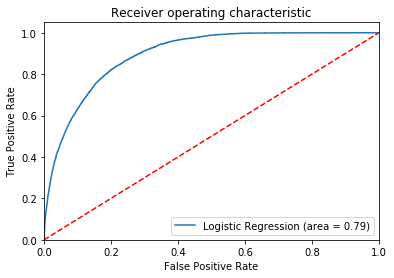

In [129]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Adjusting the decision boundary

We need to do it by hand: we first have to compute the probabilities.

In [130]:
prob_y_pred_logit = pd.DataFrame(logreg.predict_proba(X_test))
prob_y_pred_logit.head()

,0,1
0,0.999673,0.000327
1,0.416541,0.583459
2,0.999989,0.000011
3,0.602444,0.397556
4,0.257263,0.742737


Let us only consider the seconde column (probability that `INCOME` = 1)

In [131]:
prob_y_pred_logit = prob_y_pred_logit.iloc[:,1]

Here is a method made "by hand" for finding optimal threshold (it depends on needs, tradeoff between recall and precision):

First we set the range of probabilities, let's take a step of 0.01 (1%). We do not go until probability 1 because it may happen that we will encounter a division by 0 for either the precision either the recall.

In [132]:
threshold = np.arange(0.01,1,0.01)

Then we create an empty  which will store the values of `y_pred` at each iteration:

In [133]:
matrix_logit = np.zeros((X_test.shape[0],threshold.shape[0]))

Then the decision rule is simple:

$ y = \begin{cases}
1 \text{ if } P(y = 1) > threshold \\
0 \text{ otherwise}
\end{cases}$

In [134]:
for i in range(0,99):
    matrix_logit[:,i] = prob_y_pred_logit > threshold[i]

Let's store the results depeding on the threshold

In [135]:
results_logit = np.zeros((99,5))

In [136]:
for i in range(0,99):
    results_logit[i,:] = [threshold[i],
                          accuracy(y_test, matrix_logit[:,i]),
                          precision(y_test, matrix_logit[:,i]),
                          recall(y_test, matrix_logit[:,i]),
                          f1(y_test, matrix_logit[:,i])]

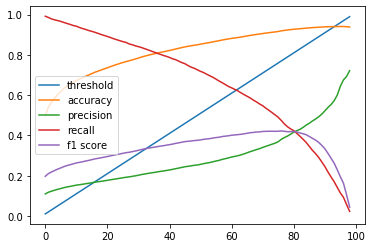

In [137]:
results_logit = pd.DataFrame(results_logit)
results_logit.columns = ["threshold", "Accuracy", "Precision", "Recall", "F1-score"]
plt.plot(results_logit.iloc[:,0], label = "threshold")
plt.plot(results_logit.iloc[:,1], label = "accuracy")
plt.plot(results_logit.iloc[:,2], label = "precision")
plt.plot(results_logit.iloc[:,3], label = "recall")
plt.plot(results_logit.iloc[:,4], label ="f1 score")
plt.legend()
plt.show()

Here is the database:

In [138]:
results_logit

,threshold,Accuracy,Precision,Recall,F1-score
0,0.01,0.497975,0.109256,0.992079,0.196834
1,0.02,0.540777,0.117685,0.985936,0.210270
2,0.03,0.565616,0.122922,0.978823,0.218415
3,0.04,0.585574,0.127642,0.974135,0.225710
4,0.05,0.603035,0.132177,0.970579,0.232668
5,0.06,0.617760,0.136147,0.966214,0.238665
6,0.07,0.633017,0.140494,0.961041,0.245150
7,0.08,0.644514,0.143889,0.956191,0.250137
8,0.09,0.654237,0.146839,0.951342,0.254409
9,0.10,0.663700,0.149790,0.946007,0.258629


As you can notice we can have a better result than before in terms of f1-score: 42% is reachable by selecting a threshold of 0.77.

Furthermore, you can obtain a crazy accuracy by selecting a threshold between 0.92 and 0.96, it gives you an accuracy of 94% ! But it is not realistic as you do not care about the rate of true positive or true negative.

In [139]:
#Best f1-score:
results_logit[results_logit.threshold == 0.77]

,threshold,Accuracy,Precision,Recall,F1-score
76,0.77,0.919559,0.380662,0.474135,0.422288


Here is the confusion matrix for this one:

In [140]:
best_f1_score_logit = pd.DataFrame(confusion_matrix(y_test, matrix_logit[:,76]),
                                   index = ["Actual 0", "Actual 1"],
                                  columns = ["Predict 0", "Predicted 1"])
best_f1_score_logit

,Predict 0,Predicted 1
Actual 0,88804,4772
Actual 1,3253,2933


In [141]:
#Best accuracy:
results_logit[results_logit.threshold == 0.97]

,threshold,Accuracy,Precision,Recall,F1-score
96,0.97,0.94098,0.675708,0.092629,0.162923


In [142]:
best_accuracy_logit = pd.DataFrame(confusion_matrix(y_test, matrix_logit[:,96]),
                                   index = ["Actual 0", "Actual 1"],
                                  columns = ["Predict 0", "Predicted 1"])
best_accuracy_logit

,Predict 0,Predicted 1
Actual 0,93301,275
Actual 1,5613,573


In this case we increase by nearly 2000 the number of false negatives. However, we decreased a lot the false positives. We have seen above the results in terms of precision and recall.

### 5.2 Extreme Gradient Boosting Classifier

For this boosting tree-based algorithm we are not going to tune the hyper-parameter as it would be very costly in terms of ressources. Howevery we will not set default parameters.

In [143]:
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param["eval_metric"] = "error"
param['eta'] = 0.3
param['max_depth'] = 6
param['subsample']= 1
param['colsample_bytree']=0.4
param['base_score'] = 0.5

It's a tree-based algorithm which will re-allocated weights to the individuals at each boosting round. The objective (or loss) function we chose the is the binary objective and the metric is the error.
We chose a max_depth of 5 (we do not want to go too far in the depth of the tree), the sample is set to 1 (all individuals will be used at each boosting round). The column sample by tree algorithm is set to 40%: it means that 40% of the variables will be randomly used at each round to build the tree, this boostrap technique avoids overfitting. The base score is 0.5 because we want to do better than tossing a coin.

In [144]:
gradient_boost = xgb.XGBClassifier(booster = 'gbtree', objective = 'binary:logistic', eval_metric = "error",
                                  eta = 0.3, max_depth = 5, subsample = 1, colsample_bytree = 0.4,
                                  base_score = 0.5)

In [145]:
gradient_boost.fit(X_fit_os, np.array(y_fit_os))
y_pred_xgb = gradient_boost.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [146]:
#Computing precision scores:
accuracy_xgb = accuracy(y_test, y_pred_xgb)
precision_xgb = precision(y_test, y_pred_xgb)
recall_xgb = recall(y_test, y_pred_xgb)
f1_xgb = f1(y_test, y_pred_xgb)

#Display:
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F-score:", f1_xgb)

Accuracy: 0.8583328321404944
Precision: 0.27159855147439216
Recall: 0.7638215324927256
F-score: 0.4007123775601069


In [147]:
xgb_model_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb),
                                   index = ["Actual 0", "Actual 1"],
                                  columns = ["Predict 0", "Predicted 1"])
xgb_model_matrix

,Predict 0,Predicted 1
Actual 0,80904,12672
Actual 1,1461,4725


Results seems good we will compare those ones with logistic regression at the end !

# Insights

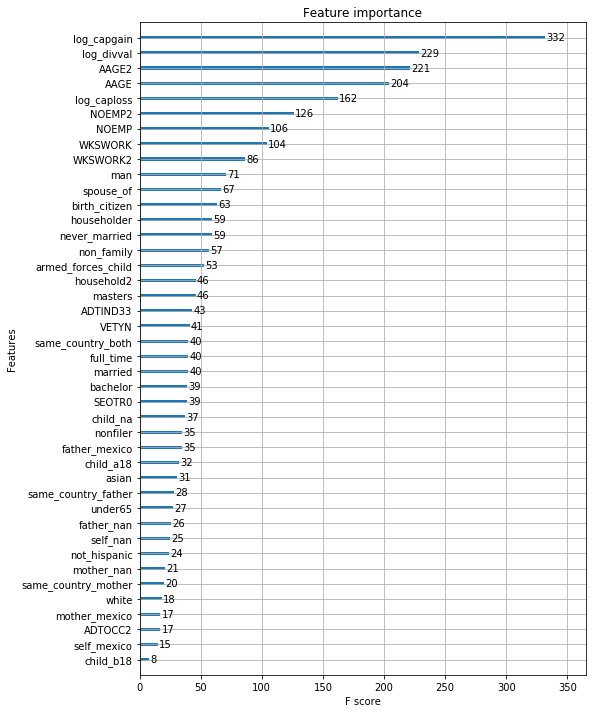

In [148]:
#Variable importance:
plt.rcParams['figure.figsize'] = [8, 12]
xgb.plot_importance(gradient_boost)
plt.show()

In terms of insights, a tree-based model like Extreme Gradient Boosting allows us to compare variable importance. The variables the most important are:
    
1- `log_capgain`: no surprise, those who earn cashflows from capital are likely to have a high income

2- `log_divval`: again, people who earn dividends are likely to earn more than 50K/year

3- `AAGE2` and `AAGE`: old people tends to have a higher income, with experience the wage increases

4- `logcaploss`: as said previously, even if you lose capital, the main information is that you have capital !

# Comparison

In order to make things comparable we should use the same comparison. Let's take the best logistic model having the same accuracy as the XGB model. By looking into the database it corresponds to a threshold of 0.53

In [149]:
results_logit[results_logit.threshold == 0.53]

,threshold,Accuracy,Precision,Recall,F1-score
52,0.53,0.859075,0.262561,0.703686,0.382429


## First comparison

In [150]:
comparison1 = np.zeros((3,5))

In [151]:
comparison1[0,0:4] = results_logit.iloc[52,1:5]
comparison1[1,0:4] = [accuracy_log1, precision_log1, recall_log1, f1_log1]
comparison1[2,0:4] = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]

comparison1 = pd.DataFrame(comparison1)
comparison1.columns = ["Accuracy", "Precison", "Recall", "F1-Score", "Model"]
comparison1.iloc[0,4] = "Best logit"
comparison1.iloc[1,4] = "First logit"
comparison1.iloc[2,4] = "XGB"

In [152]:
comparison1

,Accuracy,Precison,Recall,F1-Score,Model
0,0.859075,0.262561,0.703686,0.382429,Best logit
1,0.850364,0.253330,0.725671,0.375554,First logit
2,0.858333,0.271599,0.763822,0.400712,XGB


The best model in accuracy is the logistic model using the decision boundary.
In terms of precison, recall and F-1 Score, the XGB model wins.

However it is possible to find a threshold for which the logistic model is higher in terms of accuracy, F-1 score and precison at the same time:

In [153]:
results_logit[results_logit.threshold == 0.80]

,threshold,Accuracy,Precision,Recall,F1-score
79,0.8,0.925613,0.406198,0.432266,0.418827


## Second comparison: Accuracy only

If we only consider the accuracy here are the results:

In [154]:
pd.DataFrame({"Best Logit" : results_logit[results_logit.threshold == 0.97].iloc[0,1],
             "First Logit" : accuracy_log1,
             "XGB" : accuracy_xgb}, index = [1])

,Best Logit,First Logit,XGB
1,0.94098,0.850364,0.858333


Using the decision boundary, the logistic model is the best in terms of accuracy, it only presents 6% of error !!

Thank you for reading this project, hope you enjoyed it :)